# Basic_Junction_Network_Multicolor

### Description:
 
Attempts to learn junction parameters for multicolor noiseless junction images.

In [2]:
import pickle
import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import sys
sys.path.append('..')

from torchsummary import summary

In [3]:
# Load data

data_folder = 'foj_data/grayscale_junctions/'

# with open(data_folder + 'junction_data_24_20000_grey_multicolor_noiseless_centered.pkl','rb') as f:
#     data = pickle.load(f)

# wedges = data['wedges']
wedges_grey = data['wedges_grey']
params = data['params']
boundaries = data['boundaries']

# Sort the angles from smallest to largest
temp,_ = torch.sort(params[:,:3],axis=1)
params[:,:3] = temp

dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Copied from Calcuate_Junction_Loss

def params2dists(params, R, tau=1e-1):
    """
    Compute distance functions from field of junctions.

    Inputs
    ------
    params   Tensor of shape [N, 5, H', W'] holding N field of junctions parameters. Each
             5-vector has format (angle1, angle2, angle3, x0, y0).
    tau      Constant used for lifting the level set function to be either entirely positive
             or entirely negative when an angle approaches 0 or 2pi.


    Outputs
    -------
             Tensor of shape [N, 2, R, R, H', W'] with samples of the two distance functions for every patch
    """
    
    y, x = torch.meshgrid([torch.linspace(-1.0, 1.0, R, device=dev),
                               torch.linspace(-1.0, 1.0, R, device=dev)])
    
    x0     = params[:, 3, :, :].unsqueeze(1).unsqueeze(1)   # shape [N, 1, 1, H', W']
    y0     = params[:, 4, :, :].unsqueeze(1).unsqueeze(1)   # shape [N, 1, 1, H', W']

    # Sort so angle1 <= angle2 <= angle3 (mod 2pi)
    angles = torch.remainder(params[:, :3, :, :], 2 * np.pi)
    angles = torch.sort(angles, dim=1)[0]

    angle1 = angles[:, 0, :, :].unsqueeze(1).unsqueeze(1)   # shape [N, 1, 1, H', W']
    angle2 = angles[:, 1, :, :].unsqueeze(1).unsqueeze(1)   # shape [N, 1, 1, H', W']
    angle3 = angles[:, 2, :, :].unsqueeze(1).unsqueeze(1)   # shape [N, 1, 1, H', W']

    # Define another angle halfway between angle3 and angle1, clockwise from angle3
    # This isn't critical but it seems a bit more stable for computing gradients
    angle4 = 0.5 * (angle1 + angle3) + \
                 torch.where(torch.remainder(0.5 * (angle1 - angle3), 2 * np.pi) >= np.pi,
                             torch.ones_like(angle1) * np.pi, torch.zeros_like(angle1))

    def g(dtheta):
        # Map from [0, 2pi] to [-1, 1]
        return (dtheta / np.pi - 1.0) ** 35

    # Compute the two distance functions
    sgn42 = torch.where(torch.remainder(angle2 - angle4, 2 * np.pi) < np.pi,
                        torch.ones_like(angle2), -torch.ones_like(angle2))
    tau42 = g(torch.remainder(angle2 - angle4, 2*np.pi)) * tau

    dist42 = sgn42 * torch.min( sgn42 * (-torch.sin(angle4) * (x - x0) + torch.cos(angle4) * (y - y0)),
                               -sgn42 * (-torch.sin(angle2) * (x - x0) + torch.cos(angle2) * (y - y0))) + tau42

    sgn13 = torch.where(torch.remainder(angle3 - angle1, 2 * np.pi) < np.pi,
                        torch.ones_like(angle3), -torch.ones_like(angle3))
    tau13 = g(torch.remainder(angle3 - angle1, 2*np.pi)) * tau
    dist13 = sgn13 * torch.min( sgn13 * (-torch.sin(angle1) * (x - x0) + torch.cos(angle1) * (y - y0)),
                               -sgn13 * (-torch.sin(angle3) * (x - x0) + torch.cos(angle3) * (y - y0))) + tau13

    return torch.stack([dist13, dist42], dim=1)

def dists2indicators(dists,eta=0.00001):
    """
    Computes the indicator functions u_1, u_2, u_3 from the distance functions d_{13}, d_{12}

    Inputs
    ------
    dists   Tensor of shape [N, 2, R, R, H', W'] with samples of the two distance functions for every patch

    Outputs
    -------
            Tensor of shape [N, 3, R, R, H', W'] with samples of the three indicator functions for every patch
    """
    # Apply smooth Heaviside function to distance functions
    hdists = 0.5 * (1.0 + (2.0 / np.pi) * torch.atan(dists / eta))

    # Convert Heaviside functions into wedge indicator functions
    return torch.stack([1.0 - hdists[:, 0, :, :, :, :],
                              hdists[:, 0, :, :, :, :] * (1.0 - hdists[:, 1, :, :, :, :]),
                              hdists[:, 0, :, :, :, :] *        hdists[:, 1, :, :, :, :]], dim=1)



In [5]:
# Create data structure with optional transforms

class JunctionDataset(torch.utils.data.Dataset):
    """ Dataset with support of transforms.
    """

    def __init__(self, images, params, boundaries, wedges, transform=None):
        self.images = images
        self.params = params
        self.boundaries = boundaries
        self.wedges = wedges
        self.transform = transform

    def __getitem__(self, index):
        image = self.images[index].unsqueeze(0)
        wedge = self.wedges[index]

        if self.transform:
            image = self.transform(image)
            
        param = self.params[index].squeeze()
        boundary = self.boundaries[index]
        
        return image, param, boundary, wedge

    def __len__(self):
        return len(self.images)
    
    
# transform = transforms.Compose([
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

In [9]:
# Start by creating wedges as input to the dataset function
params = params.to(dev)
dists = params2dists(params,R=50)#.cpu().detach()
wedges = dists2indicators(dists).squeeze()#.cpu().detach()

# Create dataset
junction_data = JunctionDataset(wedges_grey, params, boundaries, wedges)#, transform=transform)
data_size = len(junction_data)

print(data_size)

train_proportion = .85
# Split dataset into training and testing
train_dataset, test_dataset = torch.utils.data.random_split(junction_data, [int(data_size*train_proportion), int(data_size*(1-train_proportion))], generator=torch.Generator().manual_seed(42))

# Create loaders for the training and testing data
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False) #len(test_dataset)

20000


In [10]:
# Reduce the conv layers now

class junctionNet(nn.Module):

    def __init__(self):
        super().__init__()
                
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.maxpool = nn.MaxPool2d(2)

        self.fc0 = nn.Linear(2048, 4096)    

        self.fc2 = nn.Linear(4096, 512)   
        self.out = nn.Linear(512, 8)   
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = F.relu(self.maxpool(x))
        x = self.conv2(x)
        x = F.relu(self.maxpool(x))
        x = self.conv3(x)
        x = F.relu(self.maxpool(x))
        x = self.conv4(x)
        x = F.relu(self.maxpool(x))
        x = x.view(-1,2048)

        x = F.relu(self.fc0(x))
#         x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        
        x_temp = x[:,:6].reshape(-1,2,3)
        x_temp = (x_temp/(torch.norm(x_temp,p=2,dim=1)).unsqueeze(1).repeat(1,2,1)).flatten(1)
        
        x = torch.cat((x_temp,x[:,6:]),axis=1)
        
        return x
        
model = junctionNet()
model = model.to(dev)
summary(model, input_size=[(1, 64, 64)])

optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)

n_epochs = 150

mse_loss = nn.MSELoss()

model.train();

for epoch in range(0,n_epochs):  # loop over the dataset multiple times

    if epoch == 0:
        train_loss_over_time = [] # to track the loss as the network trains
        test_loss_over_time = []
        
#     if epoch > 70:
#         optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)
        
    running_loss = 0
    num_batches = 0
    
    for batch_i, data in enumerate(train_loader):
        # get the input images and their corresponding labels
        num_batches += 1

        inputs, params, _, wedge = data
        
        inputs, wedge, params = inputs.to(dev), wedge.to(dev), params.to(dev)
        
        angle_params = torch.cat((torch.cos(params[:,:3]),torch.sin(params[:,:3])),axis=1)
        
        # zero the parameter (weight) gradients
        optimizer.zero_grad()
           
        # forward pass to get outputs
        output = model(inputs)
        
        # calculate the loss
        loss = mse_loss(output[:,6:],params[:,3:]) + .1*mse_loss(output[:,:6],angle_params) 
              
        # backward pass to calculate the parameter gradients
        loss.backward()

        # update the parameters
        optimizer.step()

        # to convert loss into a scalar and add it to running_loss, we use .item()
        running_loss += loss.item()

    # Calculate test data loss after each epoch
    with torch.no_grad():
        test_loss = 0
        num_batches_test = 0
        for batch_i, data in enumerate(test_loader):
            num_batches_test += 1
            
            inputs_test, params_test, _, wedges_test = data
            inputs_test, wedges_test, params_test = inputs_test.to(dev), wedges_test.to(dev), params_test.to(dev)
            
            angle_params_test = torch.cat((torch.cos(params_test[:,:3]),torch.sin(params_test[:,:3])),axis=1)
            output_test = model(inputs_test)
            
            test_loss += mse_loss(output_test[:,6:],params_test[:,3:]) + .1*mse_loss(output_test[:,:6],angle_params_test) 


                    
        test_loss_over_time.append(test_loss/num_batches_test)

    # Calculate model loss:
    avg_loss = running_loss/num_batches
    train_loss_over_time.append(avg_loss)
    
  
    print('Epoch: {}, Avg. Train Loss: {}, Avg. Test Loss: {}'.format(epoch + 1, train_loss_over_time[-1], test_loss_over_time[-1]))
    

print('Finished Training')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             320
         MaxPool2d-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          18,496
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5          [-1, 128, 16, 16]          73,856
         MaxPool2d-6            [-1, 128, 8, 8]               0
            Conv2d-7            [-1, 128, 8, 8]         147,584
         MaxPool2d-8            [-1, 128, 4, 4]               0
            Linear-9                 [-1, 4096]       8,392,704
           Linear-10                  [-1, 512]       2,097,664
           Linear-11                    [-1, 8]           4,104
Total params: 10,734,728
Trainable params: 10,734,728
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Fo

Epoch: 82, Avg. Train Loss: 0.007826511539957103, Avg. Test Loss: 0.016577262431383133
Epoch: 83, Avg. Train Loss: 0.009270999972325037, Avg. Test Loss: 0.015069570392370224
Epoch: 84, Avg. Train Loss: 0.007733896029565264, Avg. Test Loss: 0.01749383844435215
Epoch: 85, Avg. Train Loss: 0.007666572443593075, Avg. Test Loss: 0.015876194462180138
Epoch: 86, Avg. Train Loss: 0.007203737668254796, Avg. Test Loss: 0.015604931861162186
Epoch: 87, Avg. Train Loss: 0.009292437262175714, Avg. Test Loss: 0.015662511810660362
Epoch: 88, Avg. Train Loss: 0.007373381723814151, Avg. Test Loss: 0.014608597382903099
Epoch: 89, Avg. Train Loss: 0.007208900411120232, Avg. Test Loss: 0.017439110204577446
Epoch: 90, Avg. Train Loss: 0.008919826128027018, Avg. Test Loss: 0.014690597541630268
Epoch: 91, Avg. Train Loss: 0.0068232299102579845, Avg. Test Loss: 0.01570262387394905
Epoch: 92, Avg. Train Loss: 0.00676381973659291, Avg. Test Loss: 0.014755003154277802
Epoch: 93, Avg. Train Loss: 0.006661165664520

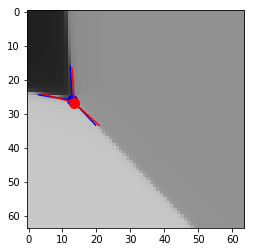

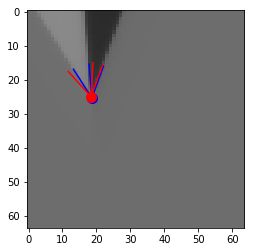

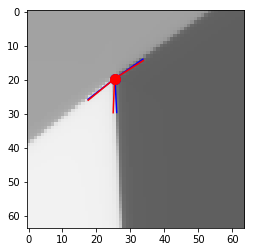

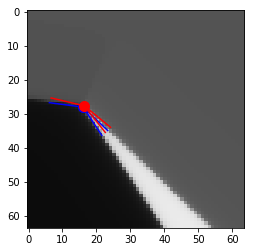

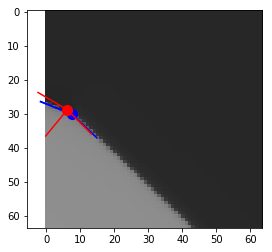

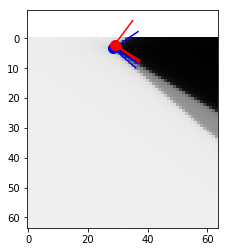

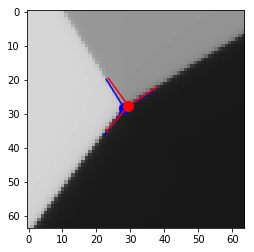

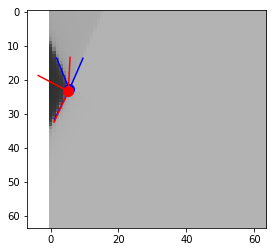

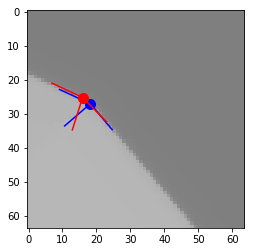

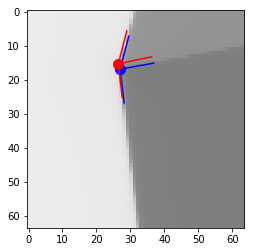

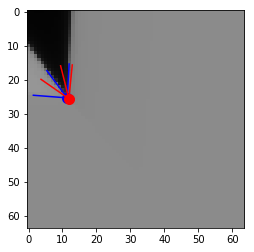

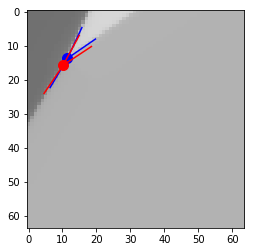

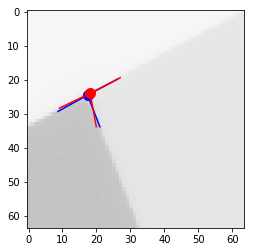

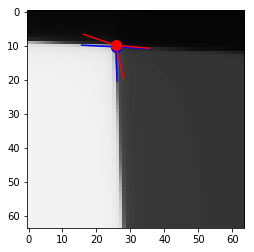

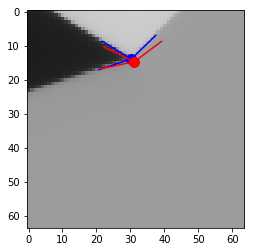

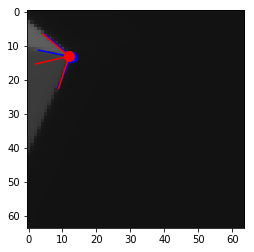

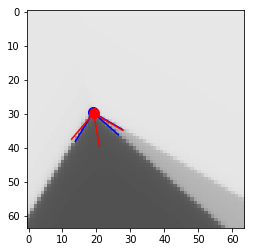

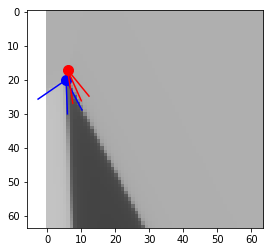

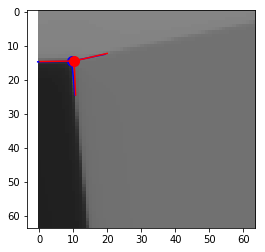

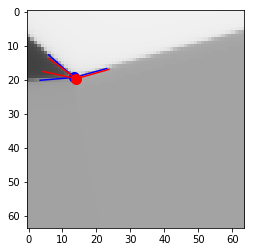

In [17]:
# What do the outputs look like? 

model.eval();

for batch_i, data in enumerate(test_loader):
    # get the input images and their corresponding labels
    inputs, params, _, _ = data
    
    inputs, params = inputs.to(dev), params.to(dev)
        
    # forward pass to get outputs
    outputs = model(inputs).squeeze().detach().cpu()
    
    gt = params.cpu().squeeze()
    angle_params = torch.cat((torch.cos(params[:,:3]),torch.sin(params[:,:3])),axis=1).detach().cpu()
    params = params.cpu()

    
for ii in range(20):
    
    plt.figure()
    plt.imshow(inputs[ii].cpu().squeeze(),cmap='gray', vmin=0, vmax=1)

    center_gt = gt[ii][3:]*32 + 32

    plt.plot(center_gt[0],center_gt[1],'bo',markersize=10)
    
    line1_end = (center_gt + 10*np.array([np.cos(gt[ii][0]),np.sin(gt[ii][0])]))
    line1 = np.concatenate((center_gt[:,np.newaxis],line1_end[:,np.newaxis]),axis=1)
    
    line2_end = (center_gt + 10*np.array([np.cos(gt[ii][1]),np.sin(gt[ii][1])]))
    line2 = np.concatenate((center_gt[:,np.newaxis],line2_end[:,np.newaxis]),axis=1)
    
    line3_end = (center_gt + 10*np.array([np.cos(gt[ii][2]),np.sin(gt[ii][2])]))
    line3 = np.concatenate((center_gt[:,np.newaxis],line3_end[:,np.newaxis]),axis=1)
    
    plt.plot(line1[0,:],line1[1,:],'-b')
    plt.plot(line2[0,:],line2[1,:],'-b')
    plt.plot(line3[0,:],line3[1,:],'-b')
    
    
    center_output = outputs[ii,6:].detach().cpu()*32+32
    
    plt.plot(center_output[0],center_output[1],'ro',markersize=10)

    line1_end = (center_output + 10*np.array([outputs[ii][0],outputs[ii][3]]))
    line1 = np.concatenate((center_output[:,np.newaxis],line1_end[:,np.newaxis]),axis=1)
    
    line2_end = (center_output + 10*np.array([outputs[ii][1],outputs[ii][4]]))
    line2 = np.concatenate((center_output[:,np.newaxis],line2_end[:,np.newaxis]),axis=1)
    
    line3_end = (center_output + 10*np.array([outputs[ii][2],outputs[ii][5]]))
    line3 = np.concatenate((center_output[:,np.newaxis],line3_end[:,np.newaxis]),axis=1)
    
    plt.plot(line1[0,:],line1[1,:],'-r')
    plt.plot(line2[0,:],line2[1,:],'-r')
    plt.plot(line3[0,:],line3[1,:],'-r')
    
    # How do the two losses compare?
    
# loss1 = mse_loss(outputs[:,6:],params[:,3:]).item() + .1*l1_loss(outputs[:,:6],angle_params).item()
# new_loss = mse_loss(outputs[:,6:],params[:,3:]).item() + .1*mse_loss(outputs[:,:6],angle_params).item()

    # New loss is lower: just use MSE




In [ ]:
# Reduce the conv layers now

class junctionNet(nn.Module):

    def __init__(self):
        super().__init__()
                
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.maxpool = nn.MaxPool2d(2)

        self.fc0 = nn.Linear(2048, 4096)   
        self.fc1 = nn.Linear(4096, 4096)  
        self.fc2 = nn.Linear(4096, 4096)  
        self.fc3 = nn.Linear(4096, 512)   
        self.out = nn.Linear(512, 8)   
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = F.relu(self.maxpool(x))
        x = self.conv2(x)
        x = F.relu(self.maxpool(x))
        x = self.conv3(x)
        x = F.relu(self.maxpool(x))
        x = self.conv4(x)
        x = F.relu(self.maxpool(x))
        x = self.conv5(x)
        x = x.view(-1,2048)

        x = F.relu(self.fc0(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.out(x)
        
        x_temp = x[:,:6].reshape(-1,2,3)
        x_temp = (x_temp/(torch.norm(x_temp,p=2,dim=1)).unsqueeze(1).repeat(1,2,1)).flatten(1)
        
        x = torch.cat((x_temp,x[:,6:]),axis=1)
        
        return x
        
model = junctionNet()
model = model.to(dev)
summary(model, input_size=[(1, 64, 64)])

optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)

n_epochs = 150

mse_loss = nn.MSELoss()

model.train();

for epoch in range(0,n_epochs):  # loop over the dataset multiple times

    if epoch == 0:
        train_loss_over_time = [] # to track the loss as the network trains
        test_loss_over_time = []
        
#     if epoch > 70:
#         optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)
        
    running_loss = 0
    num_batches = 0
    
    for batch_i, data in enumerate(train_loader):
        # get the input images and their corresponding labels
        num_batches += 1

        inputs, params, _, wedge = data
        
        inputs, wedge, params = inputs.to(dev), wedge.to(dev), params.to(dev)
        
        angle_params = torch.cat((torch.cos(params[:,:3]),torch.sin(params[:,:3])),axis=1)
        
        # zero the parameter (weight) gradients
        optimizer.zero_grad()
           
        # forward pass to get outputs
        output = model(inputs)
        
        # calculate the loss
        loss = mse_loss(output[:,6:],params[:,3:]) + .1*mse_loss(output[:,:6],angle_params) 
              
        # backward pass to calculate the parameter gradients
        loss.backward()

        # update the parameters
        optimizer.step()

        # to convert loss into a scalar and add it to running_loss, we use .item()
        running_loss += loss.item()

    # Calculate test data loss after each epoch
    with torch.no_grad():
        test_loss = 0
        num_batches_test = 0
        for batch_i, data in enumerate(test_loader):
            num_batches_test += 1
            
            inputs_test, params_test, _, wedges_test = data
            inputs_test, wedges_test, params_test = inputs_test.to(dev), wedges_test.to(dev), params_test.to(dev)
            
            angle_params_test = torch.cat((torch.cos(params_test[:,:3]),torch.sin(params_test[:,:3])),axis=1)
            output_test = model(inputs_test)
            
            test_loss += mse_loss(output_test[:,6:],params_test[:,3:]) + .1*mse_loss(output_test[:,:6],angle_params_test) 


                    
        test_loss_over_time.append(test_loss/num_batches_test)

    # Calculate model loss:
    avg_loss = running_loss/num_batches
    train_loss_over_time.append(avg_loss)
    
  
    print('Epoch: {}, Avg. Train Loss: {}, Avg. Test Loss: {}'.format(epoch + 1, train_loss_over_time[-1], test_loss_over_time[-1]))
    

print('Finished Training')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             320
         MaxPool2d-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          18,496
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5          [-1, 128, 16, 16]          73,856
         MaxPool2d-6            [-1, 128, 8, 8]               0
            Conv2d-7            [-1, 128, 8, 8]         147,584
         MaxPool2d-8            [-1, 128, 4, 4]               0
            Conv2d-9            [-1, 128, 4, 4]         147,584
           Linear-10                 [-1, 4096]       8,392,704
           Linear-11                 [-1, 4096]      16,781,312
           Linear-12                 [-1, 4096]      16,781,312
           Linear-13                  [-1, 512]       2,097,664
           Linear-14                   

Epoch: 80, Avg. Train Loss: 0.006445972405045348, Avg. Test Loss: 0.014450727961957455
Epoch: 81, Avg. Train Loss: 0.008538312695043928, Avg. Test Loss: 0.015135868452489376
Epoch: 82, Avg. Train Loss: 0.014265391014187652, Avg. Test Loss: 0.01742042601108551
Epoch: 83, Avg. Train Loss: 0.00825327801901628, Avg. Test Loss: 0.015156403183937073
Epoch: 84, Avg. Train Loss: 0.007300219567054335, Avg. Test Loss: 0.0156648401170969
Epoch: 85, Avg. Train Loss: 0.008348655518527854, Avg. Test Loss: 0.01629410870373249
Epoch: 86, Avg. Train Loss: 0.007110473554690971, Avg. Test Loss: 0.015375638380646706
Epoch: 87, Avg. Train Loss: 0.0063941728816751175, Avg. Test Loss: 0.016424009576439857
Epoch: 88, Avg. Train Loss: 0.008597473844009287, Avg. Test Loss: 0.016656816005706787
Epoch: 89, Avg. Train Loss: 0.006992005389731597, Avg. Test Loss: 0.014479580335319042
Epoch: 90, Avg. Train Loss: 0.006321455636883484, Avg. Test Loss: 0.014679023995995522
Epoch: 91, Avg. Train Loss: 0.00530041459509555

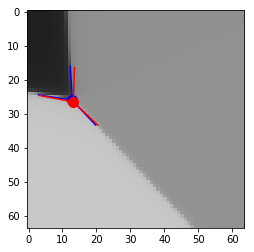

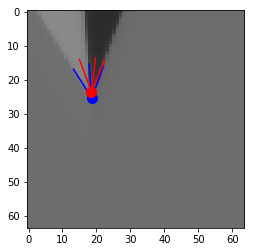

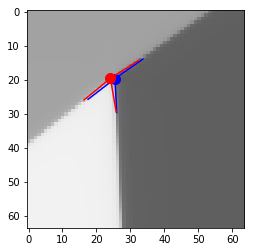

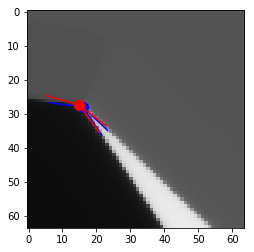

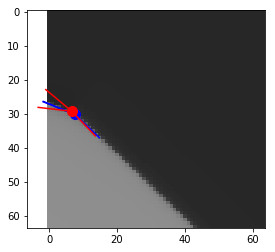

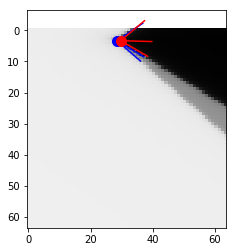

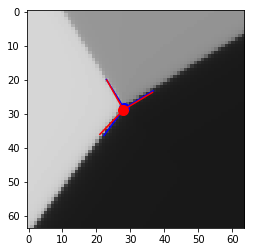

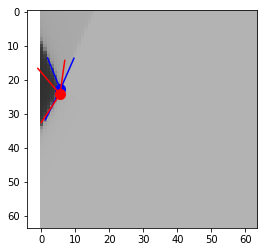

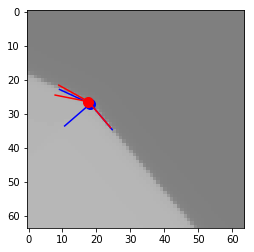

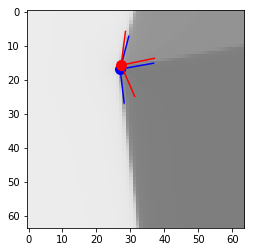

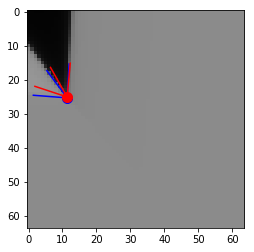

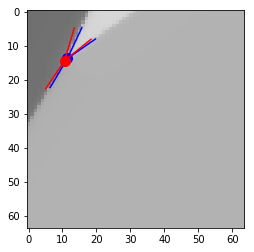

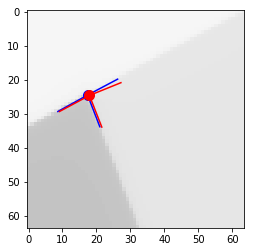

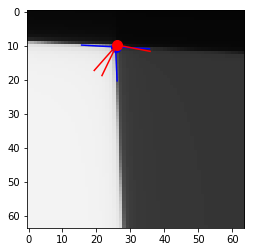

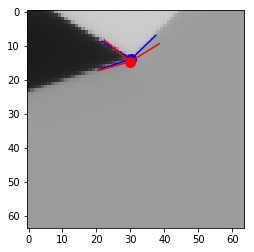

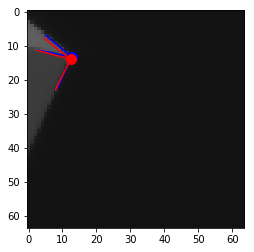

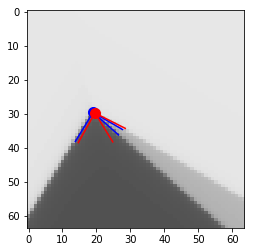

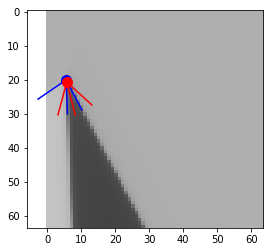

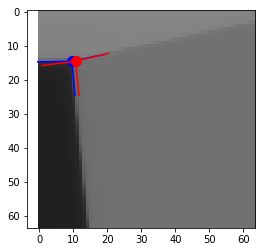

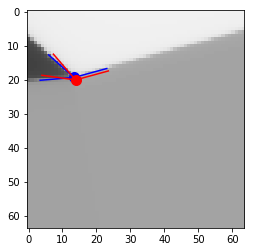

In [19]:
# What do the outputs look like? 

model.eval();

for batch_i, data in enumerate(test_loader):
    # get the input images and their corresponding labels
    inputs, params, _, _ = data
    
    inputs, params = inputs.to(dev), params.to(dev)
        
    # forward pass to get outputs
    outputs = model(inputs).squeeze().detach().cpu()
    
    gt = params.cpu().squeeze()
    angle_params = torch.cat((torch.cos(params[:,:3]),torch.sin(params[:,:3])),axis=1).detach().cpu()
    params = params.cpu()

    
for ii in range(20):
    
    plt.figure()
    plt.imshow(inputs[ii].cpu().squeeze(),cmap='gray', vmin=0, vmax=1)

    center_gt = gt[ii][3:]*32 + 32

    plt.plot(center_gt[0],center_gt[1],'bo',markersize=10)
    
    line1_end = (center_gt + 10*np.array([np.cos(gt[ii][0]),np.sin(gt[ii][0])]))
    line1 = np.concatenate((center_gt[:,np.newaxis],line1_end[:,np.newaxis]),axis=1)
    
    line2_end = (center_gt + 10*np.array([np.cos(gt[ii][1]),np.sin(gt[ii][1])]))
    line2 = np.concatenate((center_gt[:,np.newaxis],line2_end[:,np.newaxis]),axis=1)
    
    line3_end = (center_gt + 10*np.array([np.cos(gt[ii][2]),np.sin(gt[ii][2])]))
    line3 = np.concatenate((center_gt[:,np.newaxis],line3_end[:,np.newaxis]),axis=1)
    
    plt.plot(line1[0,:],line1[1,:],'-b')
    plt.plot(line2[0,:],line2[1,:],'-b')
    plt.plot(line3[0,:],line3[1,:],'-b')
    
    
    center_output = outputs[ii,6:].detach().cpu()*32+32
    
    plt.plot(center_output[0],center_output[1],'ro',markersize=10)

    line1_end = (center_output + 10*np.array([outputs[ii][0],outputs[ii][3]]))
    line1 = np.concatenate((center_output[:,np.newaxis],line1_end[:,np.newaxis]),axis=1)
    
    line2_end = (center_output + 10*np.array([outputs[ii][1],outputs[ii][4]]))
    line2 = np.concatenate((center_output[:,np.newaxis],line2_end[:,np.newaxis]),axis=1)
    
    line3_end = (center_output + 10*np.array([outputs[ii][2],outputs[ii][5]]))
    line3 = np.concatenate((center_output[:,np.newaxis],line3_end[:,np.newaxis]),axis=1)
    
    plt.plot(line1[0,:],line1[1,:],'-r')
    plt.plot(line2[0,:],line2[1,:],'-r')
    plt.plot(line3[0,:],line3[1,:],'-r')
    
    # How do the two losses compare?
    
# loss1 = mse_loss(outputs[:,6:],params[:,3:]).item() + .1*l1_loss(outputs[:,:6],angle_params).item()
# new_loss = mse_loss(outputs[:,6:],params[:,3:]).item() + .1*mse_loss(outputs[:,:6],angle_params).item()

    # New loss is lower: just use MSE





In [20]:
# Reduce the conv layers now

class junctionNet(nn.Module):

    def __init__(self):
        super().__init__()
                
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.maxpool = nn.MaxPool2d(2)

        self.fc0 = nn.Linear(2048, 4096)   
        self.fc1 = nn.Linear(4096, 4096)  
        self.fc2 = nn.Linear(4096, 4096) 
        self.fc3 = nn.Linear(4096, 2048) 
        self.fc4 = nn.Linear(2048, 512)   
        self.out = nn.Linear(512, 8)   
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = F.relu(self.maxpool(x))
        x = self.conv2(x)
        x = F.relu(self.maxpool(x))
        x = self.conv3(x)
        x = F.relu(self.maxpool(x))
        x = self.conv4(x)
        x = F.relu(self.maxpool(x))
        x = self.conv5(x)
        x = self.conv6(x)
        x = x.view(-1,2048)

        x = F.relu(self.fc0(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.out(x)
        
        x_temp = x[:,:6].reshape(-1,2,3)
        x_temp = (x_temp/(torch.norm(x_temp,p=2,dim=1)).unsqueeze(1).repeat(1,2,1)).flatten(1)
        
        x = torch.cat((x_temp,x[:,6:]),axis=1)
        
        return x
        
model = junctionNet()
model = model.to(dev)
summary(model, input_size=[(1, 64, 64)])

optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)

n_epochs = 150

mse_loss = nn.MSELoss()

model.train();

for epoch in range(0,n_epochs):  # loop over the dataset multiple times

    if epoch == 0:
        train_loss_over_time = [] # to track the loss as the network trains
        test_loss_over_time = []
        
#     if epoch > 70:
#         optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)
        
    running_loss = 0
    num_batches = 0
    
    for batch_i, data in enumerate(train_loader):
        # get the input images and their corresponding labels
        num_batches += 1

        inputs, params, _, wedge = data
        
        inputs, wedge, params = inputs.to(dev), wedge.to(dev), params.to(dev)
        
        angle_params = torch.cat((torch.cos(params[:,:3]),torch.sin(params[:,:3])),axis=1)
        
        # zero the parameter (weight) gradients
        optimizer.zero_grad()
           
        # forward pass to get outputs
        output = model(inputs)
        
        # calculate the loss
        loss = mse_loss(output[:,6:],params[:,3:]) + .1*mse_loss(output[:,:6],angle_params) 
              
        # backward pass to calculate the parameter gradients
        loss.backward()

        # update the parameters
        optimizer.step()

        # to convert loss into a scalar and add it to running_loss, we use .item()
        running_loss += loss.item()

    # Calculate test data loss after each epoch
    with torch.no_grad():
        test_loss = 0
        num_batches_test = 0
        for batch_i, data in enumerate(test_loader):
            num_batches_test += 1
            
            inputs_test, params_test, _, wedges_test = data
            inputs_test, wedges_test, params_test = inputs_test.to(dev), wedges_test.to(dev), params_test.to(dev)
            
            angle_params_test = torch.cat((torch.cos(params_test[:,:3]),torch.sin(params_test[:,:3])),axis=1)
            output_test = model(inputs_test)
            
            test_loss += mse_loss(output_test[:,6:],params_test[:,3:]) + .1*mse_loss(output_test[:,:6],angle_params_test) 


                    
        test_loss_over_time.append(test_loss/num_batches_test)

    # Calculate model loss:
    avg_loss = running_loss/num_batches
    train_loss_over_time.append(avg_loss)
    
  
    print('Epoch: {}, Avg. Train Loss: {}, Avg. Test Loss: {}'.format(epoch + 1, train_loss_over_time[-1], test_loss_over_time[-1]))
    

print('Finished Training')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             320
         MaxPool2d-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          18,496
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5          [-1, 128, 16, 16]          73,856
         MaxPool2d-6            [-1, 128, 8, 8]               0
            Conv2d-7            [-1, 128, 8, 8]         147,584
         MaxPool2d-8            [-1, 128, 4, 4]               0
            Conv2d-9            [-1, 128, 4, 4]         147,584
           Conv2d-10            [-1, 128, 4, 4]         147,584
           Linear-11                 [-1, 4096]       8,392,704
           Linear-12                 [-1, 4096]      16,781,312
           Linear-13                 [-1, 4096]      16,781,312
           Linear-14                 [-

Epoch: 78, Avg. Train Loss: 0.007281474810203209, Avg. Test Loss: 0.016259431838989258
Epoch: 79, Avg. Train Loss: 0.006535995418808478, Avg. Test Loss: 0.016230905428528786
Epoch: 80, Avg. Train Loss: 0.006718100475914338, Avg. Test Loss: 0.015342461876571178
Epoch: 81, Avg. Train Loss: 0.006113130396560711, Avg. Test Loss: 0.01415596716105938
Epoch: 82, Avg. Train Loss: 0.005479962748530157, Avg. Test Loss: 0.015269385650753975
Epoch: 83, Avg. Train Loss: 0.013275419472826316, Avg. Test Loss: 0.016797587275505066
Epoch: 84, Avg. Train Loss: 0.009128929069265723, Avg. Test Loss: 0.015344761312007904
Epoch: 85, Avg. Train Loss: 0.006738690859364236, Avg. Test Loss: 0.016868142411112785
Epoch: 86, Avg. Train Loss: 0.00659280673819868, Avg. Test Loss: 0.01586519367992878
Epoch: 87, Avg. Train Loss: 0.007677559853147935, Avg. Test Loss: 0.01642628014087677
Epoch: 88, Avg. Train Loss: 0.007409884101327728, Avg. Test Loss: 0.018235167488455772
Epoch: 89, Avg. Train Loss: 0.00770012734950903

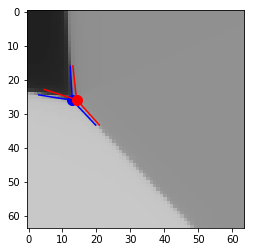

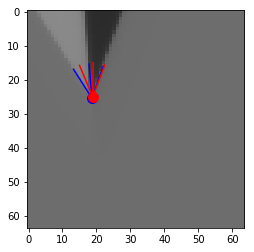

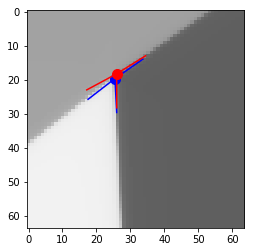

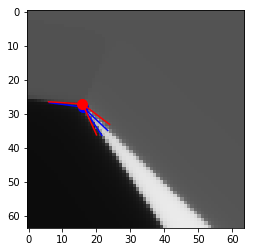

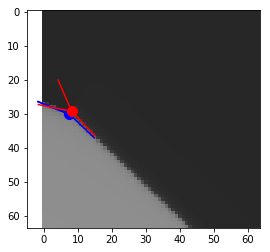

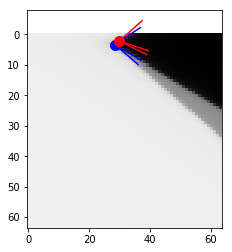

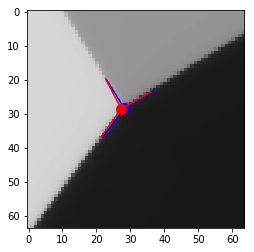

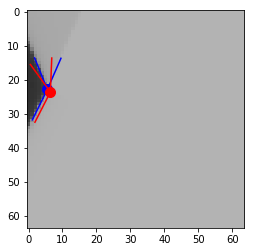

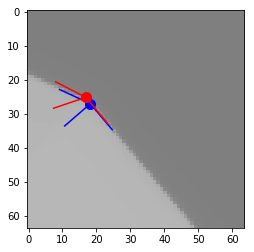

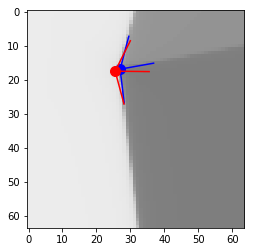

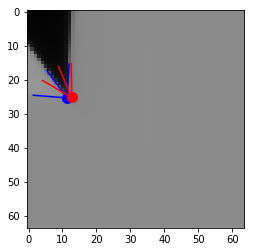

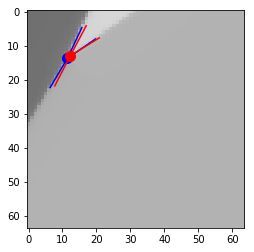

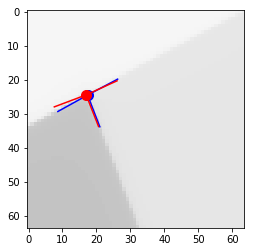

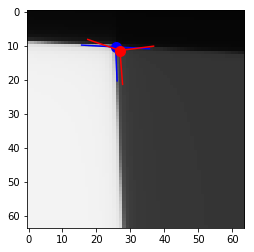

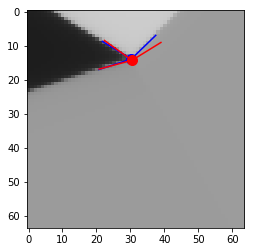

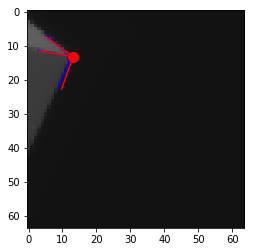

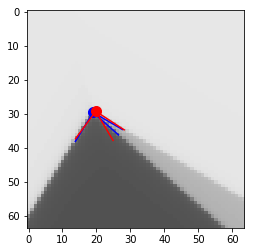

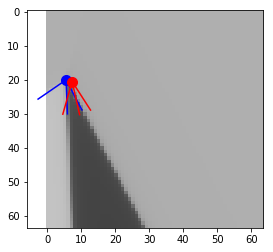

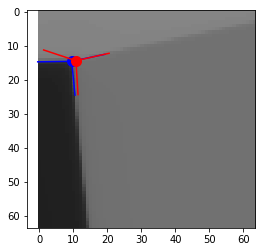

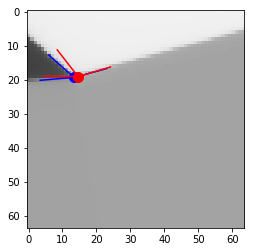

In [21]:
# What do the outputs look like? 

model.eval();

for batch_i, data in enumerate(test_loader):
    # get the input images and their corresponding labels
    inputs, params, _, _ = data
    
    inputs, params = inputs.to(dev), params.to(dev)
        
    # forward pass to get outputs
    outputs = model(inputs).squeeze().detach().cpu()
    
    gt = params.cpu().squeeze()
    angle_params = torch.cat((torch.cos(params[:,:3]),torch.sin(params[:,:3])),axis=1).detach().cpu()
    params = params.cpu()

    
for ii in range(20):
    
    plt.figure()
    plt.imshow(inputs[ii].cpu().squeeze(),cmap='gray', vmin=0, vmax=1)

    center_gt = gt[ii][3:]*32 + 32

    plt.plot(center_gt[0],center_gt[1],'bo',markersize=10)
    
    line1_end = (center_gt + 10*np.array([np.cos(gt[ii][0]),np.sin(gt[ii][0])]))
    line1 = np.concatenate((center_gt[:,np.newaxis],line1_end[:,np.newaxis]),axis=1)
    
    line2_end = (center_gt + 10*np.array([np.cos(gt[ii][1]),np.sin(gt[ii][1])]))
    line2 = np.concatenate((center_gt[:,np.newaxis],line2_end[:,np.newaxis]),axis=1)
    
    line3_end = (center_gt + 10*np.array([np.cos(gt[ii][2]),np.sin(gt[ii][2])]))
    line3 = np.concatenate((center_gt[:,np.newaxis],line3_end[:,np.newaxis]),axis=1)
    
    plt.plot(line1[0,:],line1[1,:],'-b')
    plt.plot(line2[0,:],line2[1,:],'-b')
    plt.plot(line3[0,:],line3[1,:],'-b')
    
    
    center_output = outputs[ii,6:].detach().cpu()*32+32
    
    plt.plot(center_output[0],center_output[1],'ro',markersize=10)

    line1_end = (center_output + 10*np.array([outputs[ii][0],outputs[ii][3]]))
    line1 = np.concatenate((center_output[:,np.newaxis],line1_end[:,np.newaxis]),axis=1)
    
    line2_end = (center_output + 10*np.array([outputs[ii][1],outputs[ii][4]]))
    line2 = np.concatenate((center_output[:,np.newaxis],line2_end[:,np.newaxis]),axis=1)
    
    line3_end = (center_output + 10*np.array([outputs[ii][2],outputs[ii][5]]))
    line3 = np.concatenate((center_output[:,np.newaxis],line3_end[:,np.newaxis]),axis=1)
    
    plt.plot(line1[0,:],line1[1,:],'-r')
    plt.plot(line2[0,:],line2[1,:],'-r')
    plt.plot(line3[0,:],line3[1,:],'-r')
    
    # How do the two losses compare?
    
# loss1 = mse_loss(outputs[:,6:],params[:,3:]).item() + .1*l1_loss(outputs[:,:6],angle_params).item()
# new_loss = mse_loss(outputs[:,6:],params[:,3:]).item() + .1*mse_loss(outputs[:,:6],angle_params).item()

    # New loss is lower: just use MSE






## Let's increase the size of the dataset

In [7]:
# Load data

data_folder = 'foj_data/grayscale_junctions/'

with open(data_folder + 'junction_data_64_50000_grey_variations.pkl','rb') as f:
    data = pickle.load(f)

# wedges = data['wedges']
wedges_grey = data['wedges_grey']
params = data['params']
boundaries = data['boundaries']

# Sort the angles from smallest to largest
temp,_ = torch.sort(params[:,:3],axis=1)
params[:,:3] = temp

dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Start by creating wedges as input to the dataset function
params = params.to(dev)
dists = params2dists(params,R=50)#.cpu().detach()
wedges = dists2indicators(dists).squeeze()#.cpu().detach()

# Create dataset
junction_data = JunctionDataset(wedges_grey, params, boundaries, wedges)#, transform=transform)
data_size = len(junction_data)

print(data_size)

train_proportion = .85
# Split dataset into training and testing
train_dataset, test_dataset = torch.utils.data.random_split(junction_data, [int(data_size*train_proportion), int(data_size*(1-train_proportion))], generator=torch.Generator().manual_seed(42))

# Create loaders for the training and testing data
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=200, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=200, shuffle=False) #len(test_dataset)

50000


In [8]:
# Reduce the conv layers now

class junctionNet(nn.Module):

    def __init__(self):
        super().__init__()
                
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.maxpool = nn.MaxPool2d(2)

        self.fc0 = nn.Linear(2048, 4096)   
        self.fc1 = nn.Linear(4096, 4096)  
        self.fc2 = nn.Linear(4096, 4096) 
        self.fc3 = nn.Linear(4096, 2048) 
        self.fc4 = nn.Linear(2048, 512)   
        self.out = nn.Linear(512, 8)   
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = F.relu(self.maxpool(x))
        x = self.conv2(x)
        x = F.relu(self.maxpool(x))
        x = self.conv3(x)
        x = F.relu(self.maxpool(x))
        x = self.conv4(x)
        x = F.relu(self.maxpool(x))
        x = self.conv5(x)
        x = self.conv6(x)
        x = x.view(-1,2048)

        x = F.relu(self.fc0(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.out(x)
        
        x_temp = x[:,:6].reshape(-1,2,3)
        x_temp = (x_temp/(torch.norm(x_temp,p=2,dim=1)).unsqueeze(1).repeat(1,2,1)).flatten(1)
        
        x = torch.cat((x_temp,x[:,6:]),axis=1)
        
        return x
        
model = junctionNet()
model = model.to(dev)
summary(model, input_size=[(1, 64, 64)])

optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)

n_epochs = 150

mse_loss = nn.MSELoss()

model.train();

for epoch in range(0,n_epochs):  # loop over the dataset multiple times

    if epoch == 0:
        train_loss_over_time = [] # to track the loss as the network trains
        test_loss_over_time = []
        
#     if epoch > 70:
#         optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)
        
    running_loss = 0
    num_batches = 0
    
    for batch_i, data in enumerate(train_loader):
        # get the input images and their corresponding labels
        num_batches += 1

        inputs, params, _, wedge = data
        
        inputs, wedge, params = inputs.to(dev), wedge.to(dev), params.to(dev)
        
        angle_params = torch.cat((torch.cos(params[:,:3]),torch.sin(params[:,:3])),axis=1)
        
        # zero the parameter (weight) gradients
        optimizer.zero_grad()
           
        # forward pass to get outputs
        output = model(inputs)
        
        # calculate the loss
        loss = mse_loss(output[:,6:],params[:,3:]) + .1*mse_loss(output[:,:6],angle_params) 
              
        # backward pass to calculate the parameter gradients
        loss.backward()

        # update the parameters
        optimizer.step()

        # to convert loss into a scalar and add it to running_loss, we use .item()
        running_loss += loss.item()

    # Calculate test data loss after each epoch
    with torch.no_grad():
        test_loss = 0
        num_batches_test = 0
        for batch_i, data in enumerate(test_loader):
            num_batches_test += 1
            
            inputs_test, params_test, _, wedges_test = data
            inputs_test, wedges_test, params_test = inputs_test.to(dev), wedges_test.to(dev), params_test.to(dev)
            
            angle_params_test = torch.cat((torch.cos(params_test[:,:3]),torch.sin(params_test[:,:3])),axis=1)
            output_test = model(inputs_test)
            
            test_loss += mse_loss(output_test[:,6:],params_test[:,3:]) + .1*mse_loss(output_test[:,:6],angle_params_test) 


                    
        test_loss_over_time.append(test_loss/num_batches_test)

    # Calculate model loss:
    avg_loss = running_loss/num_batches
    train_loss_over_time.append(avg_loss)
    
  
    print('Epoch: {}, Avg. Train Loss: {}, Avg. Test Loss: {}'.format(epoch + 1, train_loss_over_time[-1], test_loss_over_time[-1]))
    

print('Finished Training')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             320
         MaxPool2d-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          18,496
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5          [-1, 128, 16, 16]          73,856
         MaxPool2d-6            [-1, 128, 8, 8]               0
            Conv2d-7            [-1, 128, 8, 8]         147,584
         MaxPool2d-8            [-1, 128, 4, 4]               0
            Conv2d-9            [-1, 128, 4, 4]         147,584
           Conv2d-10            [-1, 128, 4, 4]         147,584
           Linear-11                 [-1, 4096]       8,392,704
           Linear-12                 [-1, 4096]      16,781,312
           Linear-13                 [-1, 4096]      16,781,312
           Linear-14                 [-

Epoch: 78, Avg. Train Loss: 0.015153547967543625, Avg. Test Loss: 0.03740725293755531
Epoch: 79, Avg. Train Loss: 0.013979155316669057, Avg. Test Loss: 0.01488269492983818
Epoch: 80, Avg. Train Loss: 0.00976704278121322, Avg. Test Loss: 0.013158638030290604
Epoch: 81, Avg. Train Loss: 0.008253110351889206, Avg. Test Loss: 0.013544178567826748
Epoch: 82, Avg. Train Loss: 0.016418273401109965, Avg. Test Loss: 0.014811829663813114
Epoch: 83, Avg. Train Loss: 0.010367894228198019, Avg. Test Loss: 0.013100303709506989
Epoch: 84, Avg. Train Loss: 0.009313638116552236, Avg. Test Loss: 0.014773378148674965
Epoch: 85, Avg. Train Loss: 0.007801288301606133, Avg. Test Loss: 0.01221951562911272
Epoch: 86, Avg. Train Loss: 0.007312629824425553, Avg. Test Loss: 0.011596830561757088
Epoch: 87, Avg. Train Loss: 0.007729111982623177, Avg. Test Loss: 0.012190895155072212
Epoch: 88, Avg. Train Loss: 0.007570744113900432, Avg. Test Loss: 0.011342841200530529
Epoch: 89, Avg. Train Loss: 0.00651784940128665

In [9]:
model.train();

for epoch in range(150,300):  # loop over the dataset multiple times

    if epoch == 0:
        train_loss_over_time = [] # to track the loss as the network trains
        test_loss_over_time = []
        
#     if epoch > 70:
#         optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)
        
    running_loss = 0
    num_batches = 0
    
    for batch_i, data in enumerate(train_loader):
        # get the input images and their corresponding labels
        num_batches += 1

        inputs, params, _, wedge = data
        
        inputs, wedge, params = inputs.to(dev), wedge.to(dev), params.to(dev)
        
        angle_params = torch.cat((torch.cos(params[:,:3]),torch.sin(params[:,:3])),axis=1)
        
        # zero the parameter (weight) gradients
        optimizer.zero_grad()
           
        # forward pass to get outputs
        output = model(inputs)
        
        # calculate the loss
        loss = mse_loss(output[:,6:],params[:,3:]) + .1*mse_loss(output[:,:6],angle_params) 
              
        # backward pass to calculate the parameter gradients
        loss.backward()

        # update the parameters
        optimizer.step()

        # to convert loss into a scalar and add it to running_loss, we use .item()
        running_loss += loss.item()

    # Calculate test data loss after each epoch
    with torch.no_grad():
        test_loss = 0
        num_batches_test = 0
        for batch_i, data in enumerate(test_loader):
            num_batches_test += 1
            
            inputs_test, params_test, _, wedges_test = data
            inputs_test, wedges_test, params_test = inputs_test.to(dev), wedges_test.to(dev), params_test.to(dev)
            
            angle_params_test = torch.cat((torch.cos(params_test[:,:3]),torch.sin(params_test[:,:3])),axis=1)
            output_test = model(inputs_test)
            
            test_loss += mse_loss(output_test[:,6:],params_test[:,3:]) + .1*mse_loss(output_test[:,:6],angle_params_test) 


                    
        test_loss_over_time.append(test_loss/num_batches_test)

    # Calculate model loss:
    avg_loss = running_loss/num_batches
    train_loss_over_time.append(avg_loss)
    
  
    print('Epoch: {}, Avg. Train Loss: {}, Avg. Test Loss: {}'.format(epoch + 1, train_loss_over_time[-1], test_loss_over_time[-1]))
    

print('Finished Training')

Epoch: 151, Avg. Train Loss: 0.003762944371378303, Avg. Test Loss: 0.010944575071334839
Epoch: 152, Avg. Train Loss: 0.004175062424135984, Avg. Test Loss: 0.009793421253561974
Epoch: 153, Avg. Train Loss: 0.0031463027256213023, Avg. Test Loss: 0.009711228311061859
Epoch: 154, Avg. Train Loss: 0.0022904549614950454, Avg. Test Loss: 0.009459125809371471
Epoch: 155, Avg. Train Loss: 0.0024010167504166704, Avg. Test Loss: 0.009354986250400543
Epoch: 156, Avg. Train Loss: 0.0020896000705633157, Avg. Test Loss: 0.009138014167547226
Epoch: 157, Avg. Train Loss: 0.0022964465334582985, Avg. Test Loss: 0.00983608327805996
Epoch: 158, Avg. Train Loss: 0.0027339907085409325, Avg. Test Loss: 0.009951801970601082
Epoch: 159, Avg. Train Loss: 0.002062881456692419, Avg. Test Loss: 0.009573486633598804
Epoch: 160, Avg. Train Loss: 0.001810108985371468, Avg. Test Loss: 0.00916993897408247
Epoch: 161, Avg. Train Loss: 0.005392174553475889, Avg. Test Loss: 0.01213663350790739
Epoch: 162, Avg. Train Loss: 

Epoch: 244, Avg. Train Loss: 0.0011584058751301848, Avg. Test Loss: 0.009982469491660595
Epoch: 245, Avg. Train Loss: 0.0024629936388479504, Avg. Test Loss: 0.011804522946476936
Epoch: 246, Avg. Train Loss: 0.0016319626109333526, Avg. Test Loss: 0.011012271046638489
Epoch: 247, Avg. Train Loss: 0.0011068300000816023, Avg. Test Loss: 0.009286238811910152
Epoch: 248, Avg. Train Loss: 0.0005398441170027453, Avg. Test Loss: 0.00921935960650444
Epoch: 249, Avg. Train Loss: 0.00040466991442303775, Avg. Test Loss: 0.008936217986047268
Epoch: 250, Avg. Train Loss: 0.00040858549601780993, Avg. Test Loss: 0.00920301117002964
Epoch: 251, Avg. Train Loss: 0.0004704092543718663, Avg. Test Loss: 0.009173448197543621
Epoch: 252, Avg. Train Loss: 0.0003095501747573704, Avg. Test Loss: 0.008910734206438065
Epoch: 253, Avg. Train Loss: 0.00025222263212300436, Avg. Test Loss: 0.008870674297213554
Epoch: 254, Avg. Train Loss: 0.0002242797200552717, Avg. Test Loss: 0.008819484151899815
Epoch: 255, Avg. Tra

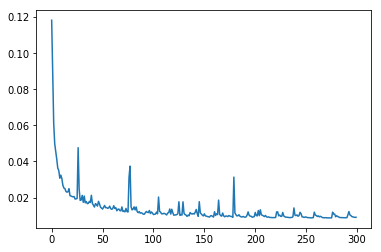

In [11]:
plt.figure()
plt.plot(test_loss_over_time)

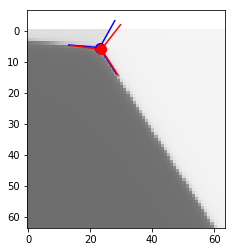

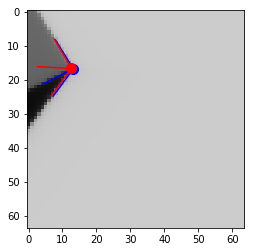

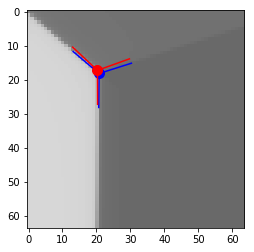

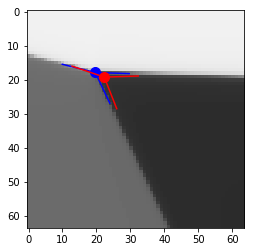

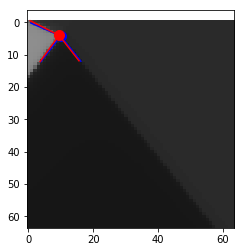

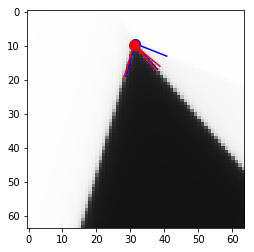

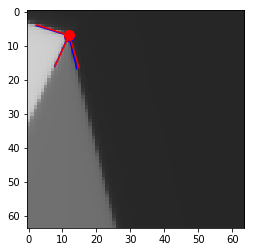

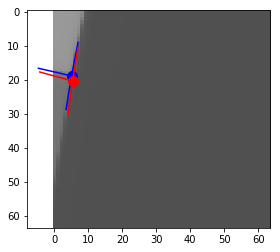

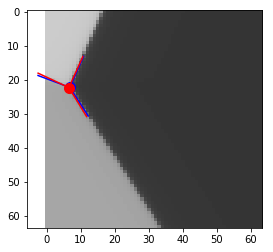

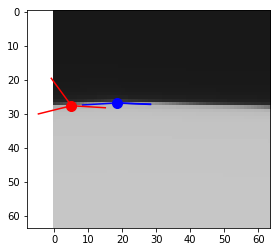

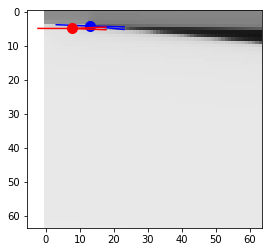

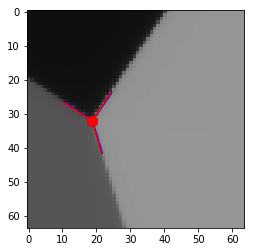

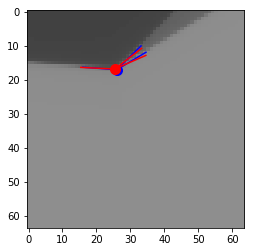

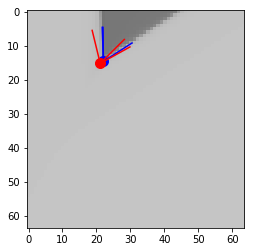

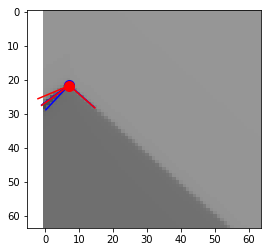

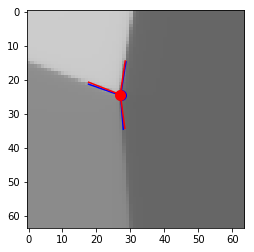

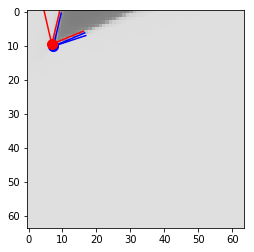

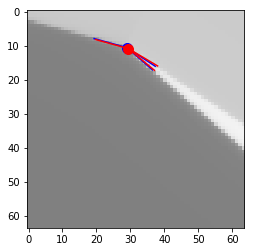

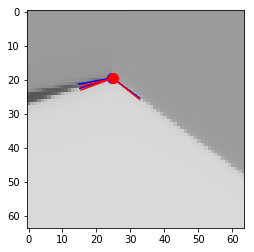

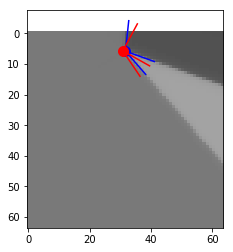

In [10]:
# What do the outputs look like? 

model.eval();

for batch_i, data in enumerate(test_loader):
    # get the input images and their corresponding labels
    inputs, params, _, _ = data
    
    inputs, params = inputs.to(dev), params.to(dev)
        
    # forward pass to get outputs
    outputs = model(inputs).squeeze().detach().cpu()
    
    gt = params.cpu().squeeze()
    angle_params = torch.cat((torch.cos(params[:,:3]),torch.sin(params[:,:3])),axis=1).detach().cpu()
    params = params.cpu()

    
for ii in range(20):
    
    plt.figure()
    plt.imshow(inputs[ii].cpu().squeeze(),cmap='gray', vmin=0, vmax=1)

    center_gt = gt[ii][3:]*32 + 32

    plt.plot(center_gt[0],center_gt[1],'bo',markersize=10)
    
    line1_end = (center_gt + 10*np.array([np.cos(gt[ii][0]),np.sin(gt[ii][0])]))
    line1 = np.concatenate((center_gt[:,np.newaxis],line1_end[:,np.newaxis]),axis=1)
    
    line2_end = (center_gt + 10*np.array([np.cos(gt[ii][1]),np.sin(gt[ii][1])]))
    line2 = np.concatenate((center_gt[:,np.newaxis],line2_end[:,np.newaxis]),axis=1)
    
    line3_end = (center_gt + 10*np.array([np.cos(gt[ii][2]),np.sin(gt[ii][2])]))
    line3 = np.concatenate((center_gt[:,np.newaxis],line3_end[:,np.newaxis]),axis=1)
    
    plt.plot(line1[0,:],line1[1,:],'-b')
    plt.plot(line2[0,:],line2[1,:],'-b')
    plt.plot(line3[0,:],line3[1,:],'-b')
    
    
    center_output = outputs[ii,6:].detach().cpu()*32+32
    
    plt.plot(center_output[0],center_output[1],'ro',markersize=10)

    line1_end = (center_output + 10*np.array([outputs[ii][0],outputs[ii][3]]))
    line1 = np.concatenate((center_output[:,np.newaxis],line1_end[:,np.newaxis]),axis=1)
    
    line2_end = (center_output + 10*np.array([outputs[ii][1],outputs[ii][4]]))
    line2 = np.concatenate((center_output[:,np.newaxis],line2_end[:,np.newaxis]),axis=1)
    
    line3_end = (center_output + 10*np.array([outputs[ii][2],outputs[ii][5]]))
    line3 = np.concatenate((center_output[:,np.newaxis],line3_end[:,np.newaxis]),axis=1)
    
    plt.plot(line1[0,:],line1[1,:],'-r')
    plt.plot(line2[0,:],line2[1,:],'-r')
    plt.plot(line3[0,:],line3[1,:],'-r')
    
    # How do the two losses compare?
    
# loss1 = mse_loss(outputs[:,6:],params[:,3:]).item() + .1*l1_loss(outputs[:,:6],angle_params).item()
# new_loss = mse_loss(outputs[:,6:],params[:,3:]).item() + .1*mse_loss(outputs[:,:6],angle_params).item()

    # New loss is lower: just use MSE



In [33]:
# Reduce the conv layers now

class junctionNet(nn.Module):

    def __init__(self):
        super().__init__()
                
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.maxpool = nn.MaxPool2d(2)

        self.fc0 = nn.Linear(2048, 4096)   
        self.fc1 = nn.Linear(4096, 4096)  
        self.fc2 = nn.Linear(4096, 4096) 
        self.fc3 = nn.Linear(4096, 4096) 
        self.fc4 = nn.Linear(4096, 2048) 
        self.fc5 = nn.Linear(2048, 512)   
        self.out = nn.Linear(512, 8)   
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = F.relu(self.maxpool(x))
        x = self.conv2(x)
        x = F.relu(self.maxpool(x))
        x = self.conv3(x)
        x = F.relu(self.maxpool(x))
        x = self.conv4(x)
        x = F.relu(self.maxpool(x))
        x = self.conv5(x)
        x = self.conv6(x)
        x = x.view(-1,2048)

        x = F.relu(self.fc0(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.out(x)
        
        x_temp = x[:,:6].reshape(-1,2,3)
        x_temp = (x_temp/(torch.norm(x_temp,p=2,dim=1)).unsqueeze(1).repeat(1,2,1)).flatten(1)
        
        x = torch.cat((x_temp,x[:,6:]),axis=1)
        
        return x
        
model = junctionNet()
model = model.to(dev)
summary(model, input_size=[(1, 64, 64)])

optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)

n_epochs = 300

mse_loss = nn.MSELoss()

model.train();

for epoch in range(0,n_epochs):  # loop over the dataset multiple times

    if epoch == 0:
        train_loss_over_time = [] # to track the loss as the network trains
        test_loss_over_time = []
        
    if epoch > 100:
        optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
        
    running_loss = 0
    num_batches = 0
    
    for batch_i, data in enumerate(train_loader):
        # get the input images and their corresponding labels
        num_batches += 1

        inputs, params, _, wedge = data
        
        inputs, wedge, params = inputs.to(dev), wedge.to(dev), params.to(dev)
        
        angle_params = torch.cat((torch.cos(params[:,:3]),torch.sin(params[:,:3])),axis=1)
        
        # zero the parameter (weight) gradients
        optimizer.zero_grad()
           
        # forward pass to get outputs
        output = model(inputs)
        
        # calculate the loss
        loss = mse_loss(output[:,6:],params[:,3:]) + .1*mse_loss(output[:,:6],angle_params) 
              
        # backward pass to calculate the parameter gradients
        loss.backward()

        # update the parameters
        optimizer.step()

        # to convert loss into a scalar and add it to running_loss, we use .item()
        running_loss += loss.item()

    # Calculate test data loss after each epoch
    with torch.no_grad():
        test_loss = 0
        num_batches_test = 0
        for batch_i, data in enumerate(test_loader):
            num_batches_test += 1
            
            inputs_test, params_test, _, wedges_test = data
            inputs_test, wedges_test, params_test = inputs_test.to(dev), wedges_test.to(dev), params_test.to(dev)
            
            angle_params_test = torch.cat((torch.cos(params_test[:,:3]),torch.sin(params_test[:,:3])),axis=1)
            output_test = model(inputs_test)
            
            test_loss += mse_loss(output_test[:,6:],params_test[:,3:]) + .1*mse_loss(output_test[:,:6],angle_params_test) 


                    
        test_loss_over_time.append(test_loss/num_batches_test)

    # Calculate model loss:
    avg_loss = running_loss/num_batches
    train_loss_over_time.append(avg_loss)
    
  
    print('Epoch: {}, Avg. Train Loss: {}, Avg. Test Loss: {}'.format(epoch + 1, train_loss_over_time[-1], test_loss_over_time[-1]))
    

print('Finished Training')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             320
         MaxPool2d-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          18,496
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5          [-1, 128, 16, 16]          73,856
         MaxPool2d-6            [-1, 128, 8, 8]               0
            Conv2d-7            [-1, 128, 8, 8]         147,584
         MaxPool2d-8            [-1, 128, 4, 4]               0
            Conv2d-9            [-1, 128, 4, 4]         147,584
           Conv2d-10            [-1, 128, 4, 4]         147,584
           Linear-11                 [-1, 4096]       8,392,704
           Linear-12                 [-1, 4096]      16,781,312
           Linear-13                 [-1, 4096]      16,781,312
           Linear-14                 [-

Epoch: 77, Avg. Train Loss: 0.007569450012762362, Avg. Test Loss: 0.011072507128119469
Epoch: 78, Avg. Train Loss: 0.008180290543662271, Avg. Test Loss: 0.011344068683683872
Epoch: 79, Avg. Train Loss: 0.008930565579466417, Avg. Test Loss: 0.011512544006109238
Epoch: 80, Avg. Train Loss: 0.007698697121070584, Avg. Test Loss: 0.01088038645684719
Epoch: 81, Avg. Train Loss: 0.0064966780944626795, Avg. Test Loss: 0.011173860169947147
Epoch: 82, Avg. Train Loss: 0.006460657438368235, Avg. Test Loss: 0.01211736723780632
Epoch: 83, Avg. Train Loss: 0.010103155294774284, Avg. Test Loss: 0.011443478986620903
Epoch: 84, Avg. Train Loss: 0.0059946063816320025, Avg. Test Loss: 0.011594288982450962
Epoch: 85, Avg. Train Loss: 0.005624500481508007, Avg. Test Loss: 0.011127650737762451
Epoch: 86, Avg. Train Loss: 0.006101724127648582, Avg. Test Loss: 0.011006220243871212
Epoch: 87, Avg. Train Loss: 0.006040973331945393, Avg. Test Loss: 0.010960654355585575
Epoch: 88, Avg. Train Loss: 0.0059404220440

Epoch: 170, Avg. Train Loss: 0.0006253790075370403, Avg. Test Loss: 0.008532015606760979
Epoch: 171, Avg. Train Loss: 0.0005954730070574305, Avg. Test Loss: 0.008472477085888386
Epoch: 172, Avg. Train Loss: 0.0006239911166408882, Avg. Test Loss: 0.008542045950889587
Epoch: 173, Avg. Train Loss: 0.0006273995714367066, Avg. Test Loss: 0.008586069568991661
Epoch: 174, Avg. Train Loss: 0.0005600450883188805, Avg. Test Loss: 0.008572298102080822
Epoch: 175, Avg. Train Loss: 0.0006052748419829762, Avg. Test Loss: 0.008652553893625736
Epoch: 176, Avg. Train Loss: 0.0005614041504362694, Avg. Test Loss: 0.008544648997485638
Epoch: 177, Avg. Train Loss: 0.0005365003035906615, Avg. Test Loss: 0.00849461741745472
Epoch: 178, Avg. Train Loss: 0.00050968464935076, Avg. Test Loss: 0.008623480796813965
Epoch: 179, Avg. Train Loss: 0.0005108842612823533, Avg. Test Loss: 0.008561425842344761
Epoch: 180, Avg. Train Loss: 0.0005055335534795541, Avg. Test Loss: 0.00851866789162159
Epoch: 181, Avg. Train Lo

Epoch: 262, Avg. Train Loss: 0.00013989346284837956, Avg. Test Loss: 0.008329348638653755
Epoch: 263, Avg. Train Loss: 0.00014335491462635805, Avg. Test Loss: 0.008348274044692516
Epoch: 264, Avg. Train Loss: 0.00013295484704983163, Avg. Test Loss: 0.0081945164129138
Epoch: 265, Avg. Train Loss: 0.00013037088740848774, Avg. Test Loss: 0.008262719959020615
Epoch: 266, Avg. Train Loss: 0.00013440798022817087, Avg. Test Loss: 0.008233409374952316
Epoch: 267, Avg. Train Loss: 0.00013923520419611093, Avg. Test Loss: 0.008286663331091404
Epoch: 268, Avg. Train Loss: 0.00012941112273980474, Avg. Test Loss: 0.008268855512142181
Epoch: 269, Avg. Train Loss: 0.00012747565874782885, Avg. Test Loss: 0.008220028132200241
Epoch: 270, Avg. Train Loss: 0.0001258323655478512, Avg. Test Loss: 0.008217963390052319
Epoch: 271, Avg. Train Loss: 0.00012723300638122205, Avg. Test Loss: 0.008161984384059906
Epoch: 272, Avg. Train Loss: 0.00013108768684438652, Avg. Test Loss: 0.008183258585631847
Epoch: 273, A

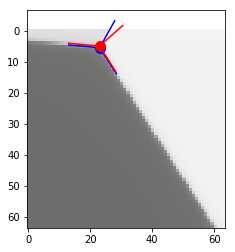

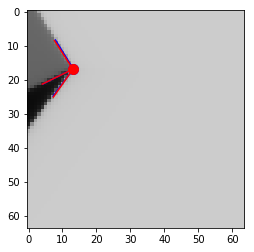

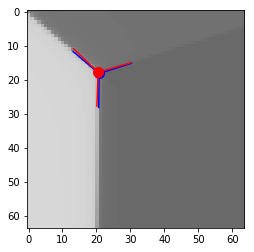

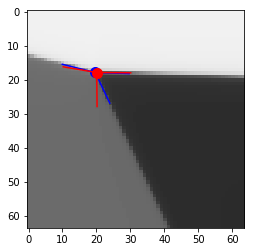

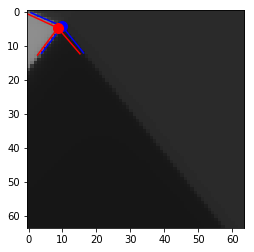

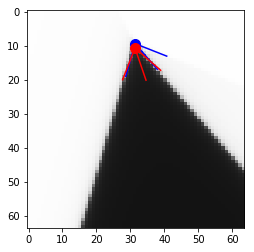

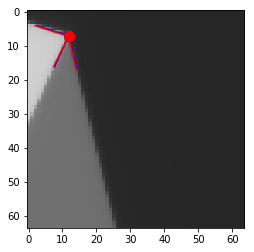

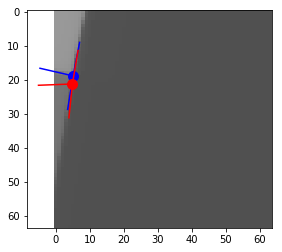

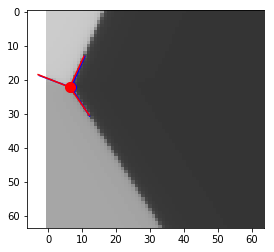

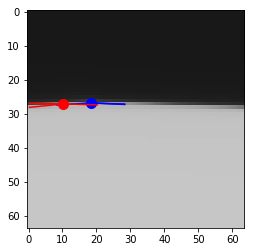

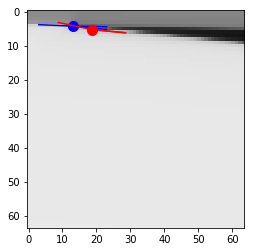

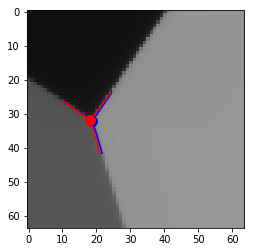

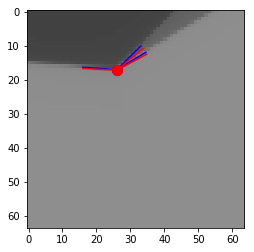

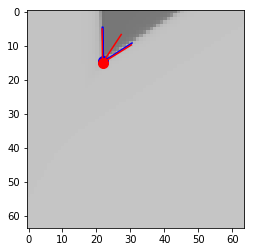

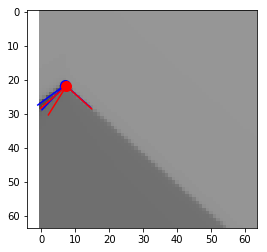

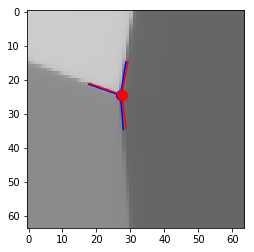

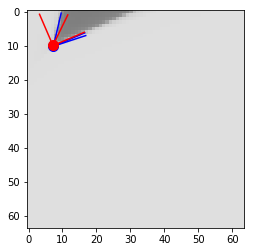

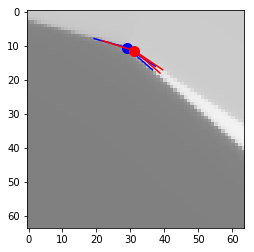

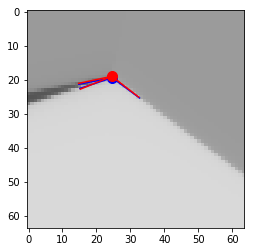

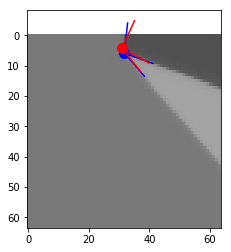

In [32]:
# What do the outputs look like? 

model.eval();

for batch_i, data in enumerate(test_loader):
    # get the input images and their corresponding labels
    inputs, params, _, _ = data
    
    inputs, params = inputs.to(dev), params.to(dev)
        
    # forward pass to get outputs
    outputs = model(inputs).squeeze().detach().cpu()
    
    gt = params.cpu().squeeze()
    angle_params = torch.cat((torch.cos(params[:,:3]),torch.sin(params[:,:3])),axis=1).detach().cpu()
    params = params.cpu()

    
for ii in range(20):
    
    plt.figure()
    plt.imshow(inputs[ii].cpu().squeeze(),cmap='gray', vmin=0, vmax=1)

    center_gt = gt[ii][3:]*32 + 32

    plt.plot(center_gt[0],center_gt[1],'bo',markersize=10)
    
    line1_end = (center_gt + 10*np.array([np.cos(gt[ii][0]),np.sin(gt[ii][0])]))
    line1 = np.concatenate((center_gt[:,np.newaxis],line1_end[:,np.newaxis]),axis=1)
    
    line2_end = (center_gt + 10*np.array([np.cos(gt[ii][1]),np.sin(gt[ii][1])]))
    line2 = np.concatenate((center_gt[:,np.newaxis],line2_end[:,np.newaxis]),axis=1)
    
    line3_end = (center_gt + 10*np.array([np.cos(gt[ii][2]),np.sin(gt[ii][2])]))
    line3 = np.concatenate((center_gt[:,np.newaxis],line3_end[:,np.newaxis]),axis=1)
    
    plt.plot(line1[0,:],line1[1,:],'-b')
    plt.plot(line2[0,:],line2[1,:],'-b')
    plt.plot(line3[0,:],line3[1,:],'-b')
    
    
    center_output = outputs[ii,6:].detach().cpu()*32+32
    
    plt.plot(center_output[0],center_output[1],'ro',markersize=10)

    line1_end = (center_output + 10*np.array([outputs[ii][0],outputs[ii][3]]))
    line1 = np.concatenate((center_output[:,np.newaxis],line1_end[:,np.newaxis]),axis=1)
    
    line2_end = (center_output + 10*np.array([outputs[ii][1],outputs[ii][4]]))
    line2 = np.concatenate((center_output[:,np.newaxis],line2_end[:,np.newaxis]),axis=1)
    
    line3_end = (center_output + 10*np.array([outputs[ii][2],outputs[ii][5]]))
    line3 = np.concatenate((center_output[:,np.newaxis],line3_end[:,np.newaxis]),axis=1)
    
    plt.plot(line1[0,:],line1[1,:],'-r')
    plt.plot(line2[0,:],line2[1,:],'-r')
    plt.plot(line3[0,:],line3[1,:],'-r')
    
    # How do the two losses compare?
    
# loss1 = mse_loss(outputs[:,6:],params[:,3:]).item() + .1*l1_loss(outputs[:,:6],angle_params).item()
# new_loss = mse_loss(outputs[:,6:],params[:,3:]).item() + .1*mse_loss(outputs[:,:6],angle_params).item()

    # New loss is lower: just use MSE




In [30]:
# def overlap_loss(output, target, R=50):

#     pred_wedges = dists2indicators(params2dists(output.unsqueeze(-1).unsqueeze(-1),R)).squeeze()
    
#     loss1 = torch.sum(pred_wedges + target - 2*pred_wedges*target,axis=(1,2,3))/torch.numel(pred_wedges)
#     loss2 = torch.sum(pred_wedges[:,[2,0,1],:,:] + target - 2*pred_wedges[:,[2,0,1],:,:]*target,axis=(1,2,3))/torch.numel(pred_wedges)
#     loss3 = torch.sum(pred_wedges[:,[1,2,0],:,:] + target - 2*pred_wedges[:,[1,2,0],:,:]*target,axis=(1,2,3))/torch.numel(pred_wedges)

#     min_loss,_ = torch.Tensor.min(torch.stack((loss1,loss2,loss3),axis=1),axis=1)
    
#     return min_loss

# model.train();

# for epoch in range(300,500):  # loop over the dataset multiple times

#     if epoch == 0:
#         train_loss_over_time = [] # to track the loss as the network trains
#         test_loss_over_time = []
        
#     if epoch > 100:
#         optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
        
#     running_loss = 0
#     num_batches = 0
    
#     for batch_i, data in enumerate(train_loader):
#         # get the input images and their corresponding labels
#         num_batches += 1

#         inputs, params, _, wedge = data
        
#         inputs, wedge, params = inputs.to(dev), wedge.to(dev), params.to(dev)
        
#         angle_params = torch.cat((torch.cos(params[:,:3]),torch.sin(params[:,:3])),axis=1)
        
#         # zero the parameter (weight) gradients
#         optimizer.zero_grad()
           
#         # forward pass to get outputs
#         output_temp = model(inputs)
        
#         output = torch.cat((torch.atan2(output_temp[:,3:6],output_temp[:,:3]),output_temp[:,6:]),axis=1)

#         # calculate the loss
#         loss = overlap_loss(output,wedge).mean()
              
#         # backward pass to calculate the parameter gradients
#         loss.backward()

#         # update the parameters
#         optimizer.step()

#         # to convert loss into a scalar and add it to running_loss, we use .item()
#         running_loss += loss.item()

#     # Calculate test data loss after each epoch
#     with torch.no_grad():
#         test_loss = 0
#         num_batches_test = 0
#         for batch_i, data in enumerate(test_loader):
#             num_batches_test += 1
            
#             inputs_test, params_test, _, wedges_test = data
#             inputs_test, wedges_test, params_test = inputs_test.to(dev), wedges_test.to(dev), params_test.to(dev)
            
#             angle_params_test = torch.cat((torch.cos(params_test[:,:3]),torch.sin(params_test[:,:3])),axis=1)
#             output_test_temp = model(inputs_test)
            
#             output_test = torch.cat((torch.atan2(output_test_temp[:,3:6],output_test_temp[:,:3]),output_test_temp[:,6:]),axis=1)
            
#             test_loss += overlap_loss(output_test,wedges_test).mean()

                    
#         test_loss_over_time.append(test_loss/num_batches_test)

#     # Calculate model loss:
#     avg_loss = running_loss/num_batches
#     train_loss_over_time.append(avg_loss)
    
  
#     print('Epoch: {}, Avg. Train Loss: {}, Avg. Test Loss: {}'.format(epoch + 1, train_loss_over_time[-1], test_loss_over_time[-1]))
    

# print('Finished Training')

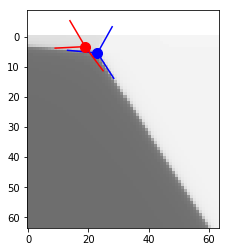

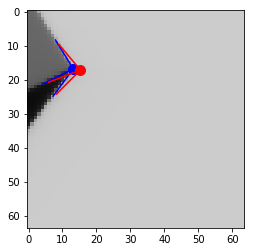

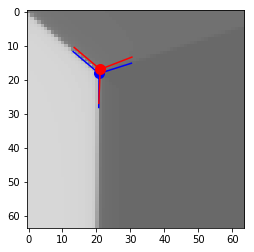

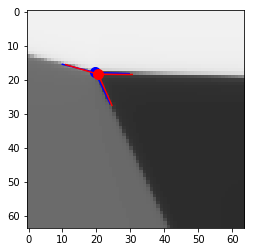

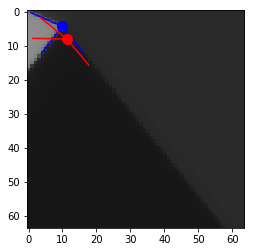

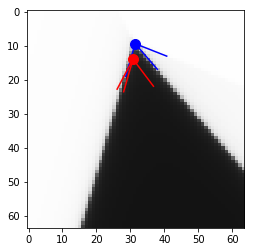

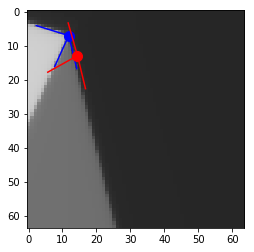

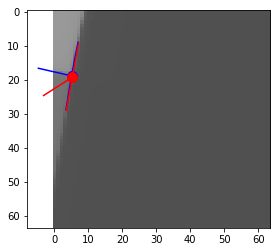

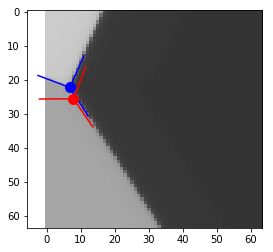

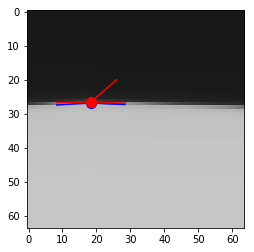

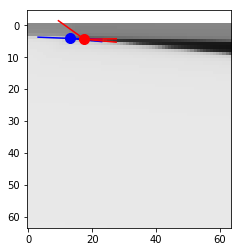

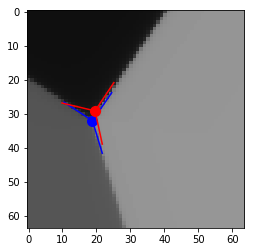

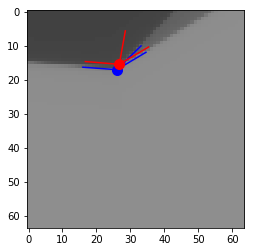

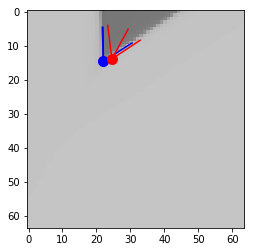

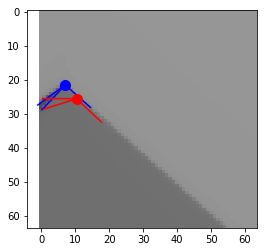

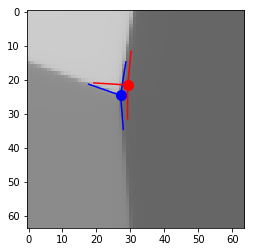

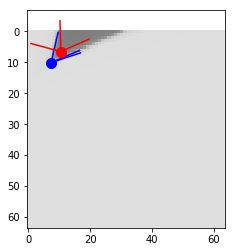

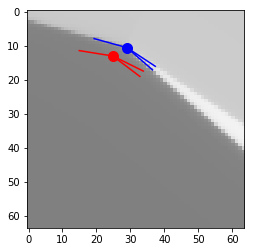

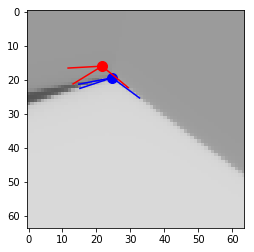

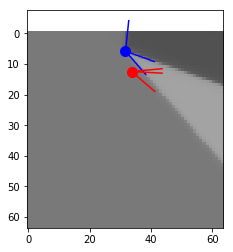

In [29]:
# What do the outputs look like? 

model.eval();

for batch_i, data in enumerate(test_loader):
    # get the input images and their corresponding labels
    inputs, params, _, _ = data
    
    inputs, params = inputs.to(dev), params.to(dev)
        
    # forward pass to get outputs
    outputs = model(inputs).squeeze().detach().cpu()
    
    gt = params.cpu().squeeze()
    angle_params = torch.cat((torch.cos(params[:,:3]),torch.sin(params[:,:3])),axis=1).detach().cpu()
    params = params.cpu()

    
for ii in range(20):
    
    plt.figure()
    plt.imshow(inputs[ii].cpu().squeeze(),cmap='gray', vmin=0, vmax=1)

    center_gt = gt[ii][3:]*32 + 32

    plt.plot(center_gt[0],center_gt[1],'bo',markersize=10)
    
    line1_end = (center_gt + 10*np.array([np.cos(gt[ii][0]),np.sin(gt[ii][0])]))
    line1 = np.concatenate((center_gt[:,np.newaxis],line1_end[:,np.newaxis]),axis=1)
    
    line2_end = (center_gt + 10*np.array([np.cos(gt[ii][1]),np.sin(gt[ii][1])]))
    line2 = np.concatenate((center_gt[:,np.newaxis],line2_end[:,np.newaxis]),axis=1)
    
    line3_end = (center_gt + 10*np.array([np.cos(gt[ii][2]),np.sin(gt[ii][2])]))
    line3 = np.concatenate((center_gt[:,np.newaxis],line3_end[:,np.newaxis]),axis=1)
    
    plt.plot(line1[0,:],line1[1,:],'-b')
    plt.plot(line2[0,:],line2[1,:],'-b')
    plt.plot(line3[0,:],line3[1,:],'-b')
    
    
    center_output = outputs[ii,6:].detach().cpu()*32+32
    
    plt.plot(center_output[0],center_output[1],'ro',markersize=10)

    line1_end = (center_output + 10*np.array([outputs[ii][0],outputs[ii][3]]))
    line1 = np.concatenate((center_output[:,np.newaxis],line1_end[:,np.newaxis]),axis=1)
    
    line2_end = (center_output + 10*np.array([outputs[ii][1],outputs[ii][4]]))
    line2 = np.concatenate((center_output[:,np.newaxis],line2_end[:,np.newaxis]),axis=1)
    
    line3_end = (center_output + 10*np.array([outputs[ii][2],outputs[ii][5]]))
    line3 = np.concatenate((center_output[:,np.newaxis],line3_end[:,np.newaxis]),axis=1)
    
    plt.plot(line1[0,:],line1[1,:],'-r')
    plt.plot(line2[0,:],line2[1,:],'-r')
    plt.plot(line3[0,:],line3[1,:],'-r')
    
    # How do the two losses compare?
    
# loss1 = mse_loss(outputs[:,6:],params[:,3:]).item() + .1*l1_loss(outputs[:,:6],angle_params).item()
# new_loss = mse_loss(outputs[:,6:],params[:,3:]).item() + .1*mse_loss(outputs[:,:6],angle_params).item()

    # New loss is lower: just use MSE



